# EcoMath Introduction
In this notebook we will explore some of the basic functionality of the EcoMath.jl library that is currently under development. This project has it's origin in the postgraduate Ecological Mathematics course taught by Dr. Marco Tulio Angulo at the National Autonomous University of Mexico. 


We begin by loading the main module and creating some synthetic data.

In [1]:
include(joinpath(dirname(@__DIR__), joinpath("src", "EcoMath.jl")));
using LinearAlgebra: eigvals
using Random
using Logging

Random.seed!(14);

## Competetive Lotka-Voltera

We center our analysis on the [Competetive Lotka-Voltera model](https://en.wikipedia.org/wiki/Competitive_Lotka%E2%80%93Volterra_equations):

$$
\dot N= N ⊙ r ⊙ (1 - (A × N))
$$
Where N is the population of each species in vector form, $A=\{c_{ij}\}_{nxn}$ the species's interaction matrix, with $c_{ij}$ representing the effect of the j$^{th}$ species ($s_j$) on the i$^{th}$ species ($s_i$). Where $r$ is the per-capita growth rate of each species in vector form and $\odot$ is the Hadamard or elementwise product.

### Simple Example
Most of the modules functions have default parameter values that can help in understanding their use without too much effort. Let's explore the following model:

$$
N = \left(\begin{matrix}
    c_{11} & c_{12} \\
    c_{21}  & c_{22}
    \end{matrix} \right) =
    \left( \begin{matrix}
    1 & 0.4 \\
    0.5 & 1 
    \end{matrix} \right) 
$$  
$$
r = \left( r_1, r_2 \right) = \left( 10, 12\right)
$$

With initial population values of $u_0=(0.5, 0.3)$. This is the default for the $\texttt{simulate_spec}$ function.

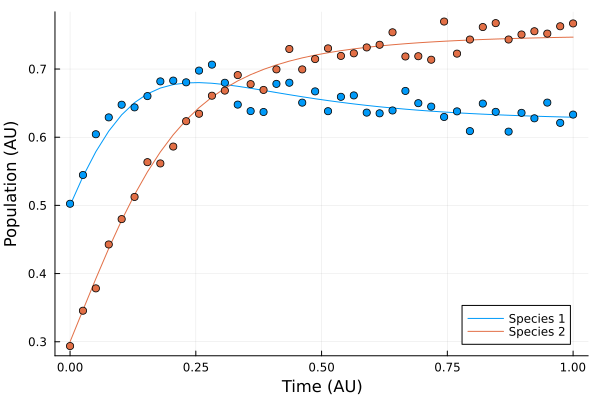

In [2]:
t = LinRange(0, 1, 40)
data, prob, p = simulate_spec(mult_spec; t=t, noise = 1.5, return_params=true);
simulation_plotter(data, prob, p, t)

## More Complex Systems

Given that our model is in vectorized form, we can simulate an ecosystem with an arbitrary number of species. Let's look at an example with four ($n=4$) species.

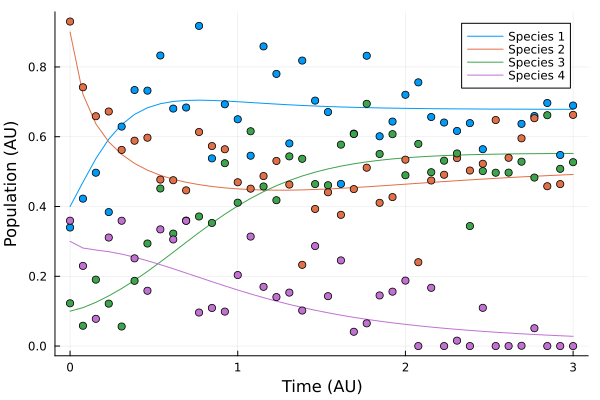

In [3]:
t = LinRange(0, 3, 40)
r = [10, 12, 8, 15]
u0 = [0.4, 0.9, 0.1, 0.3]
A = [1.0 0.3 0.2 0.5
     0.3 1.0 0.6 0.6
     0.3 0.5 1.0 0.7
     0.3 0.9 0.6 1.0]

data, prob, p = simulate_spec(
                    mult_spec; 
                    noise = 10, 
                    t=t, 
                    r=r, 
                    A=A, 
                    u0=u0, 
                    return_params=true);
simulation_plotter(data, prob, p, t)

With very little code we are able to solve a competitive lotka-volterra system and plot simulated noisy observations of that system. 

We observe that while species 1-3 converge to a stable population value, species 4 seems to die out. This was infact entirely predictable given that we know that to create a stable ecosystem, $N$ must have all positive eigenvalues. As we can see below, this is not the case in our example.

In [4]:
eigvals(A)

4-element Vector{ComplexF64}:
 0.3552708184808281 - 0.09533266781984764im
 0.3552708184808281 + 0.09533266781984764im
 0.7858130723741124 + 0.0im
 2.5036452906642315 + 0.0im

## Retrodiction
Now, let's say you have a set of observations from a competitive ecological system and would like to infer the underlying CLV model parameters. We can leverage Turing.jl to perform [Bayesian parameter estimation](https://turing.ml/dev/tutorials/10-bayesian-differential-equations/). The benefit of this approach is that we also obtain an easily interpretable measure of uncertainty in our estimates.

We begin by defining our prior or baseline belief for the system. In this case we set:

$$
c_{ij} =
\begin{cases}
1    &\text{ if} \;\; i=j\\
0.5  &\text{ otherwise}
\end{cases}
$$
And $r_i = 5$ for all $i$.

In [10]:
Aₚ = [1.0 0.5 0.5 0.5
      0.5 1.0 0.5 0.5
      0.5 0.5 1.0 0.5
      0.5 0.5 0.5 1.0]
# For efficiency the matrix must be flattened before passing it
Aₚ = vec(Aₚ)
rₚ = [5, 5, 5, 5];

With our priors, we define our prior model and run multiple Monte Carlo Markov Chains to find the distributions of parameters that best fit our model. In the cell below, we plot the estimated models from a sample of the most likely parameters from each chain. As we can see, this does a fairly good job of estimating the underlying system from which we generated the data, inspite of the large amount of noise we introduced.

In [6]:
model = get_eco_model(data, prob, t, [Aₚ], [rₚ]);
chain = Logging.with_logger(Logging.NullLogger()) do;
            get_chain(model; iterations=1000, n_chains=2);
end;

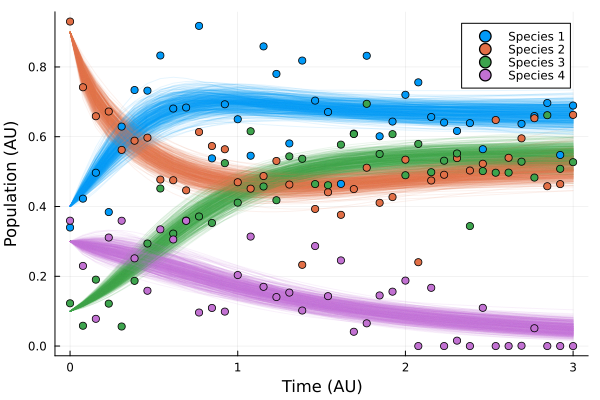

In [7]:
predictions = chain_retrodiction(chain, t; n_samples=500);
plot_retrodiction(predictions, t; data=data, alpha=0.1)

We can plot the original systems and compare them to the estimated ones to get a better idea of how good our estimate is.

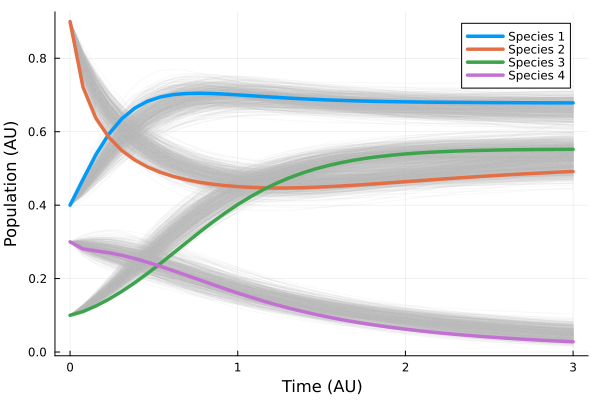

In [8]:
plt = plot_retrodiction(predictions, t; alpha=0.1, colors="#BBBBBB")
simulation_plotter(
    data, 
    prob, 
    p, 
    t; 
    points=false, 
    sim_plot=plt, 
    ln_kwargs=Dict(:linewidth => 3.5))

## Getting More From Your Model
Those wishing to better understand what's going on behind the scenes can leverage Turing's extensive functionallity to plot a summary of the estimates.

In [9]:
plot(chain)